In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tikzplotlib as tpl

In [2]:
from scipy.special import gamma
from scipy.linalg import expm, sqrtm, logm
from scipy.stats import multivariate_normal as mv_norm
from scipy.stats import invwishart, chi2

%matplotlib inline

In [3]:
#helper functions
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("Psi matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

def my_box(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

def make_2D_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        xx.append(matrix)
        
    return(xx)

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def create_spd_matrix(p=2, eps=10e-3):
    
    #create two symmetric positive-definite matrices
    X_ = torch.rand(p,p)
    X_sym = (X_ + X_.T)/2
    lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + eps
    X_spd = X_sym + torch.eye(p) * lambda_X_min
    print("X_spd is spd: ", is_pos_def(X_spd))
    
    return(X_spd.cpu().numpy())

    

(301, 2, 2)
(301,)


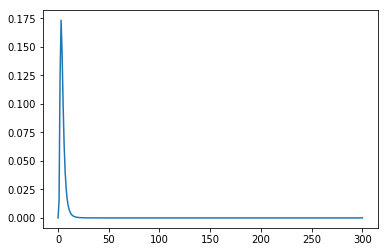

In [4]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = np.array([[4,2],
             [2,3]])
is_pos_def(s)

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = invwishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

# Inverse Wishart Bridge

In [5]:
"""functions"""

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def inverse_wishart_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest = np.linalg.det(X)**(-(v+p+1)/2) * np.exp(-1/2*np.trace(Psi @ np.linalg.inv(X)))
    return(const * rest)

def inverse_wishart_t_logm_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest =  np.linalg.det(expm(X))**(-(v+p-1)/2) * np.exp(-0.5*np.trace(Psi @ np.linalg.inv(expm(X))))
    return(const * rest)

def inverse_wishart_t_sqrtm_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest =  np.linalg.det(X)**(-(v+p)) * np.exp(-0.5*np.trace(Psi @ np.linalg.inv(X.T@X)))
    return(const * rest)

def inverse_wishart_mu(nu, p, Psi):
    r = 1/(nu+p+1)*Psi
    return(r.reshape(p,p))

def inverse_wishart_Sigma(nu, p, Psi):
    vp1 = nu + p +1
    R = 2/(vp1)**3 * np.kron(Psi, Psi)
    return(R)

def multivariate_normal_pdf_test(X, mu, Sigma):
    k = np.shape(X)[0]
    a = (2*np.pi)**(-k/2) * np.linalg.det(Sigma)**(-1/2)
    x_mu = (X-mu).reshape(-1)
    b = np.exp(-1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu)
    return(a*b)

"""Transformation: logm"""

def inverse_wishart_t_logm_mu(nu, p, Psi):
    r =  logm(1/(nu+p-1) * Psi)
    return(r.reshape(p,p))

def inverse_wishart_t_logm_Sigma(nu, p, Psi):
    return(2/(nu + p - 1) * np.eye(p**2))

def log_mv_normal_back(X, mu, Sigma):
    X_ = logm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(np.linalg.inv(X)))
    
"""Transformation: sqrtm"""

def inverse_wishart_t_sqrtm_mu(nu, p, Psi):
    r =  sqrtm(1/(nu+p)*Psi)
    return(r.reshape(p,p))

def kronecker(A, B):
    return(torch.einsum("ij,kl->ikjl", A, B).reshape(A.size(0)*B.size(0),  A.size(1)*B.size(1)))


def inverse_wishart_t_sqrtm_Sigma(nu, p, Psi):
    
    Psi = torch.Tensor(Psi)
    Psi_inv = torch.inverse(Psi)
    Psi_sqrtm = torch.Tensor(sqrtm(Psi.detach().numpy()))
    Psi_inv_sqrtm = torch.inverse(Psi_sqrtm)
    one = kronecker(torch.eye(p), Psi)
    two = torch.inverse((kronecker(Psi_sqrtm, Psi_inv_sqrtm) + torch.eye(p**2)))
    R = 1/(nu + p)**2 * one @ two
    
    return(R.detach().numpy()) 
    
def sqrt_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(sqrtm(X)))


# logm Bridge

In [6]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_inverse_Wishart_bridge_logm(xx, xxt, ns, s, p=2, save=False, filename='', show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = inverse_wishart_mu(n1, p=p, Psi=s)
    mode2 = inverse_wishart_mu(n2, p=p, Psi=s)
    mode3 = inverse_wishart_mu(n3, p=p, Psi=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = inverse_wishart_Sigma(n1, p=p, Psi=s)
    sigma2 = inverse_wishart_Sigma(n2, p=p, Psi=s)
    sigma3 = inverse_wishart_Sigma(n3, p=p, Psi=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    iw1 = []
    iw2 = []
    iw3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        iw_1 = inverse_wishart_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_pdf(X=x, v=n3, Psi=s)
        iw1.append(iw_1)
        iw2.append(iw_2)
        iw3.append(iw_3)
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(iw1_lpa)
        normal2.append(iw2_lpa)
        normal3.append(iw3_lpa)

    iw1 = np.array(iw1)
    iw2 = np.array(iw2)
    iw3 = np.array(iw3)
    
    rescale_normal1 = np.max(iw1)/np.max(normal1)
    rescale_normal2 = np.max(iw2)/np.max(normal2)
    rescale_normal3 = np.max(iw3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    
    ######### logm transformation

    mode1_t_logm = inverse_wishart_t_logm_mu(n1, p=p, Psi=s)
    mode2_t_logm = inverse_wishart_t_logm_mu(n2, p=p, Psi=s)
    mode3_t_logm = inverse_wishart_t_logm_mu(n3, p=p, Psi=s)

    sigma1_t_logm = inverse_wishart_t_logm_Sigma(n1, p=p, Psi=s)
    sigma2_t_logm = inverse_wishart_t_logm_Sigma(n2, p=p, Psi=s)
    sigma3_t_logm = inverse_wishart_t_logm_Sigma(n3, p=p, Psi=s)

    is_pos_def(sigma1_t_logm)
    is_pos_def(sigma2_t_logm)
    is_pos_def(sigma3_t_logm)

    iw1_t_logm = []
    iw2_t_logm = []
    iw3_t_logm = []
    iw1_lpa_t_logm = []
    iw2_lpa_t_logm = []
    iw3_lpa_t_logm = []

    for x in xxt:
        iw_1 = inverse_wishart_t_logm_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_t_logm_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_t_logm_pdf(X=x, v=n3, Psi=s)
        iw1_t_logm.append(iw_1)
        iw2_t_logm.append(iw_2)
        iw3_t_logm.append(iw_3)
        #
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_logm, Sigma=sigma1_t_logm)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_logm, Sigma=sigma2_t_logm)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_logm, Sigma=sigma3_t_logm)
        iw1_lpa_t_logm.append(iw1_lpa)
        iw2_lpa_t_logm.append(iw2_lpa)
        iw3_lpa_t_logm.append(iw3_lpa)

    #rescale for visibility
    iw1_t_logm = np.array(iw1_t_logm)
    iw2_t_logm = np.array(iw2_t_logm)
    iw3_t_logm = np.array(iw3_t_logm)
    
    rescale1_t_logm = np.max(iw1_t_logm)/np.max(iw1_lpa_t_logm)
    rescale2_t_logm = np.max(iw2_t_logm)/np.max(iw2_lpa_t_logm)
    rescale3_t_logm = np.max(iw3_t_logm)/np.max(iw3_lpa_t_logm)

    iw1_lpa_t_logm = np.array(iw1_lpa_t_logm) * rescale1_t_logm
    iw2_lpa_t_logm = np.array(iw2_lpa_t_logm) * rescale2_t_logm
    iw3_lpa_t_logm = np.array(iw3_lpa_t_logm) * rescale3_t_logm

    ######### back transform #########

    iw1_back = []
    iw2_back = []
    iw3_back = []

    for x in xx:
        iw1_back.append(log_mv_normal_back(x, mode1_t_logm, sigma1_t_logm))
        iw2_back.append(log_mv_normal_back(x, mode2_t_logm, sigma2_t_logm))
        iw3_back.append(log_mv_normal_back(x, mode3_t_logm, sigma3_t_logm))
        
    rescale_back1 = np.max(iw1)/np.max(iw1_back)
    rescale_back2 = np.max(iw2)/np.max(iw2_back)
    rescale_back3 = np.max(iw3)/np.max(iw3_back)

    iw1_back = np.array(iw1_back) * rescale_back1
    iw2_back = np.array(iw2_back) * rescale_back2 
    iw3_back = np.array(iw3_back) * rescale_back3 
    
    """Plots"""
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    xlabel_size=25
    ylabel_size=25
    title_size=25
    lw = 3

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(26,6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,4))
        
    axs[0].plot(iw1, 'r-', lw=lw)
    axs[0].plot(iw2, 'b-', lw=lw)
    axs[0].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size})

    axs[1].plot(iw1_t_logm, 'r', lw=lw)
    axs[1].plot(iw2_t_logm, 'b', lw=lw)
    axs[1].plot(iw3_t_logm, 'k', lw=lw, label="$\mathcal{IW}$")
    axs[1].plot(iw1_lpa_t_logm, 'r--', lw=lw)
    axs[1].plot(iw2_lpa_t_logm, 'b--', lw=lw)
    axs[1].plot(iw3_lpa_t_logm, 'k--', lw=lw, label="$\mathcal{N}$")
    #axs[1].set_yticklabels([])
    #axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in logm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size})

    if show_back:
        axs[2].plot(iw1, 'r-', lw=lw)
        axs[2].plot(iw2, 'b-', lw=lw)
        axs[2].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$");
        axs[2].plot(iw1_back, 'r--', lw=lw)
        axs[2].plot(iw2_back, 'b--', lw=lw)
        axs[2].plot(iw3_back, 'k--', lw=lw, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    if save:
        plt.savefig(filename)
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


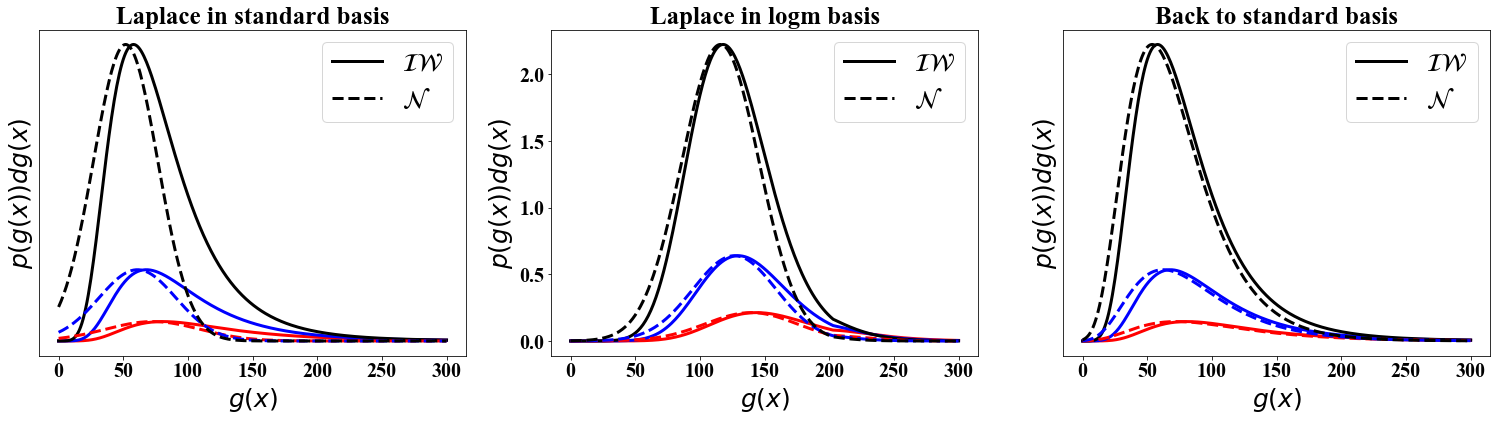

In [7]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 1.5, 300 +1)
a_22 = np.linspace(0.1, 1.5, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

a_11_t = np.linspace(-2.3, 1.1, 300 +1)
a_22_t = np.linspace(-2.3, 1.1, 300 +1)

r = 0.5
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False,
                                 filename='inverse_wishart_logm_bridge.pdf', show_back=True)

-0.9
(301, 2, 2)


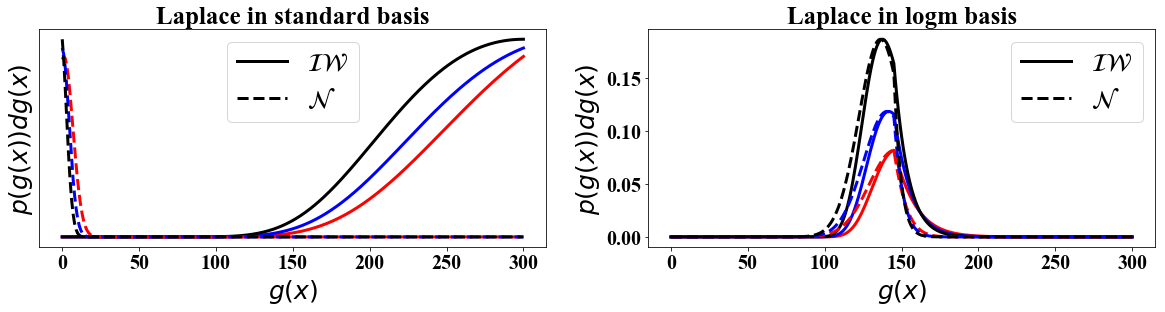

-0.8
(301, 2, 2)


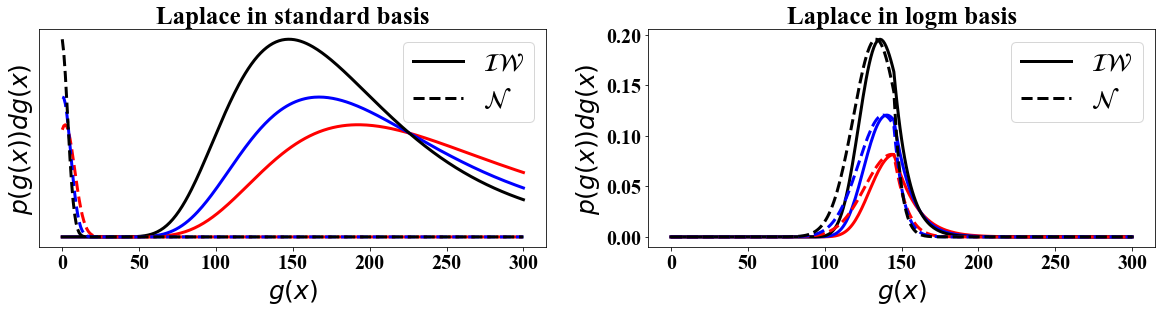

-0.7
(301, 2, 2)


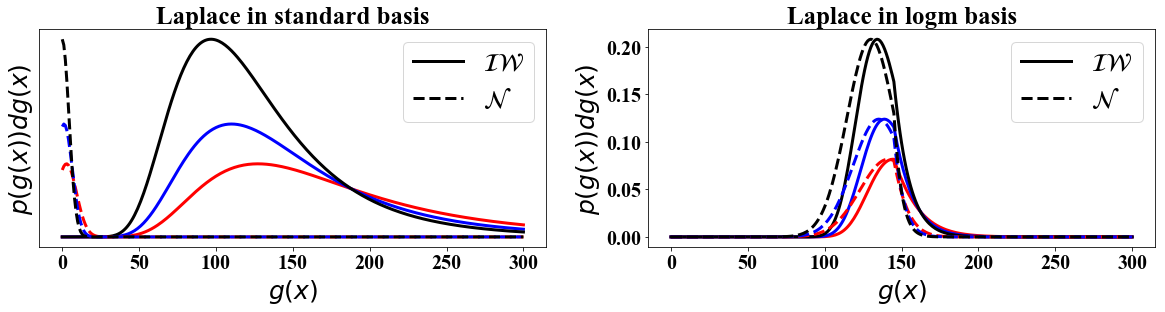

-0.6
(301, 2, 2)


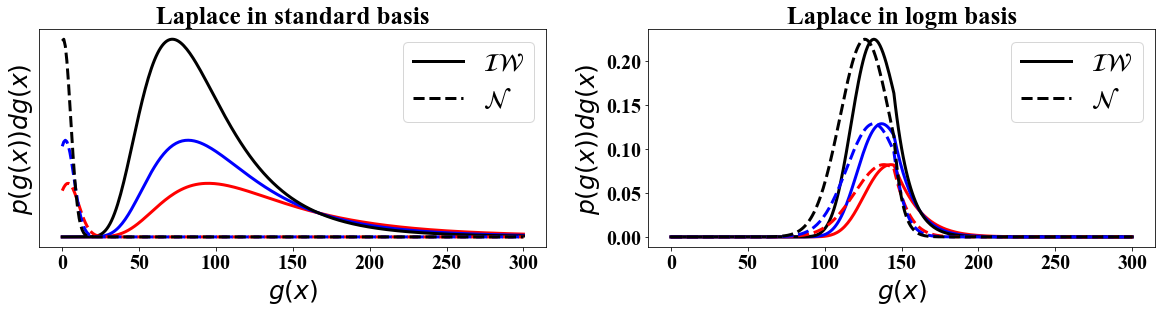

-0.5
(301, 2, 2)


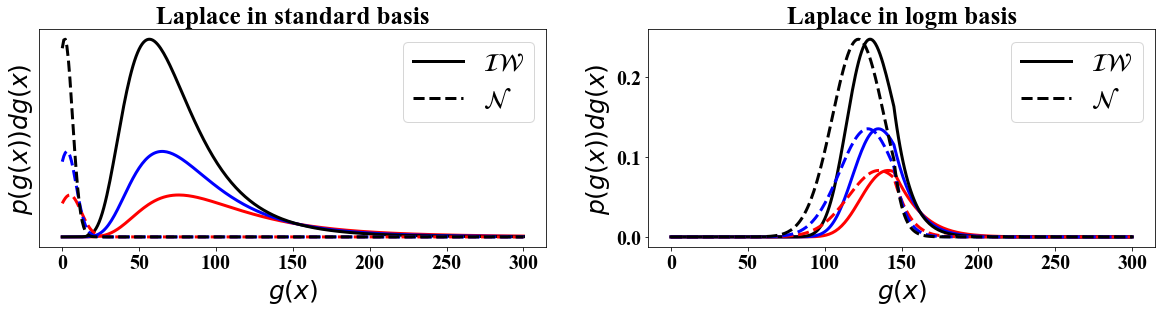

-0.4
(301, 2, 2)


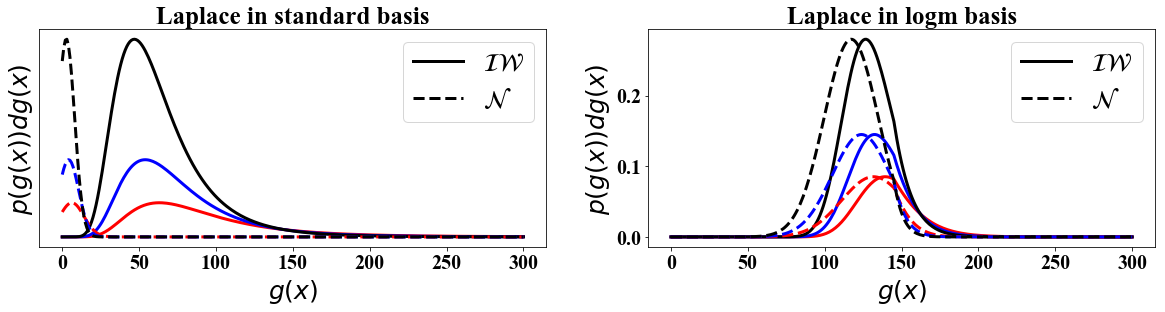

-0.29999999999999993
(301, 2, 2)


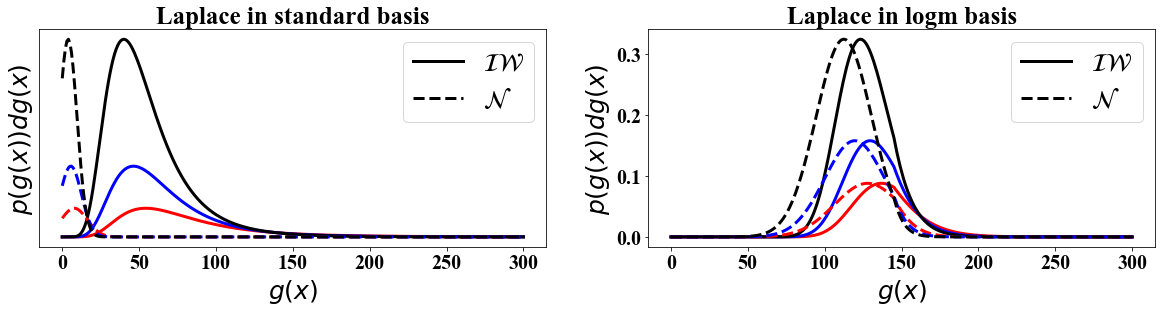

-0.19999999999999996
(301, 2, 2)


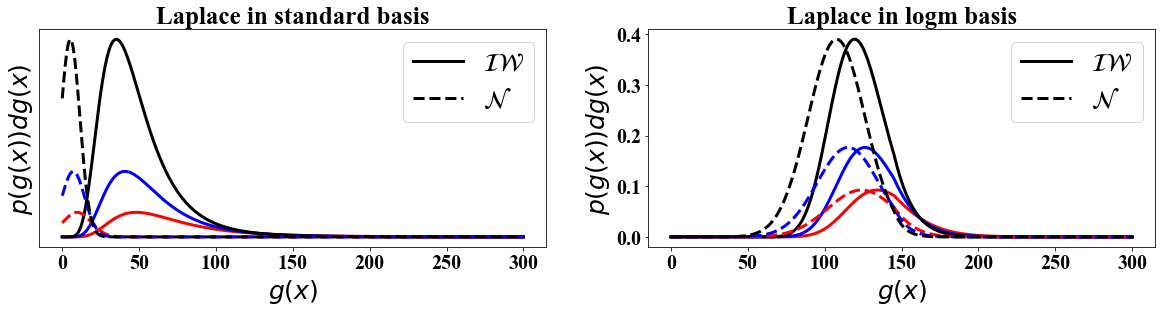

-0.09999999999999998
(301, 2, 2)


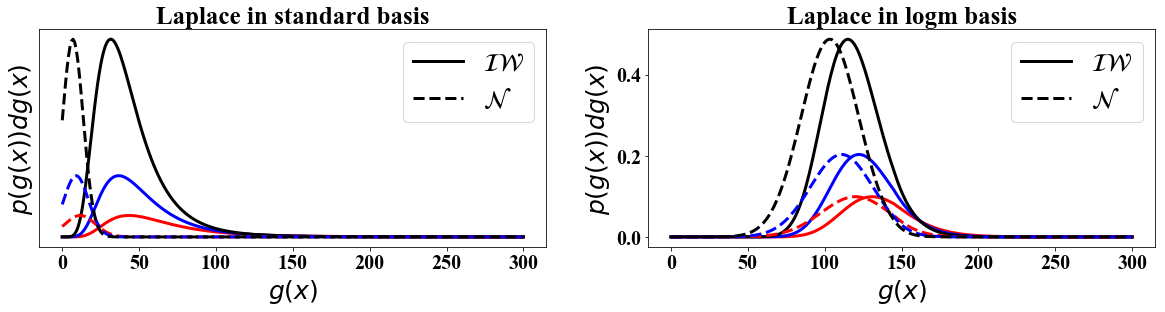

0.0
(301, 2, 2)


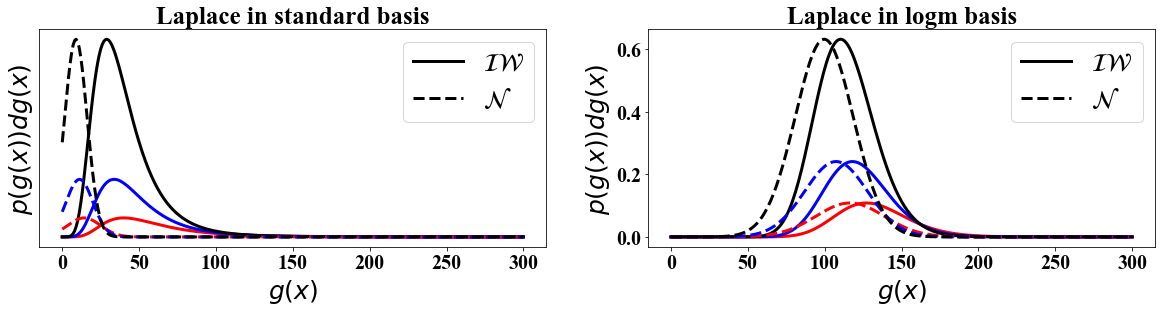

0.09999999999999998
(301, 2, 2)


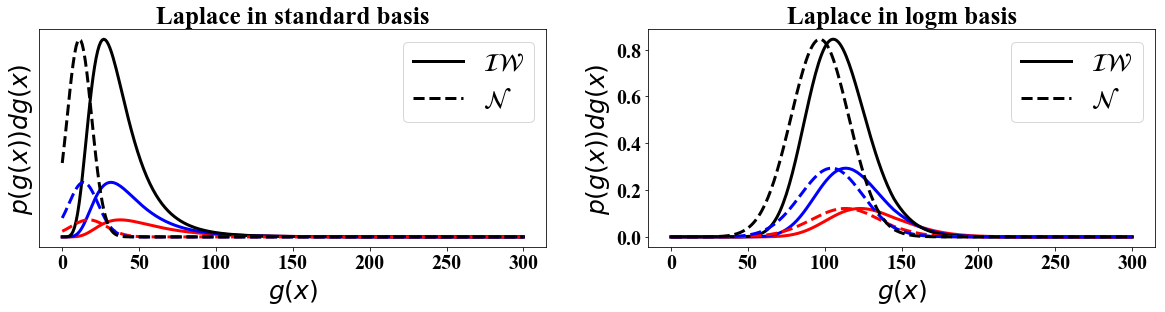

0.20000000000000007
(301, 2, 2)


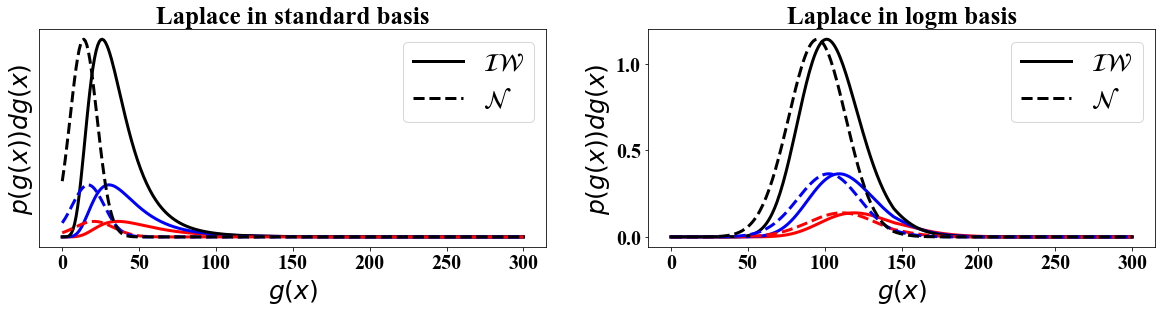

0.30000000000000016
(301, 2, 2)


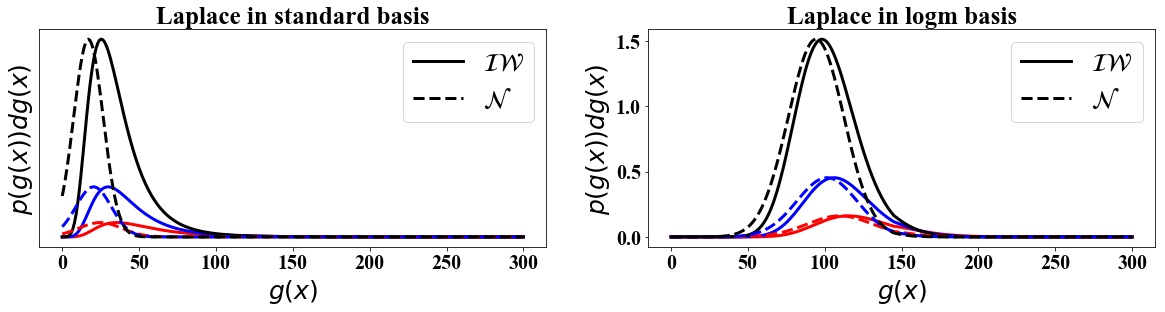

0.4
(301, 2, 2)


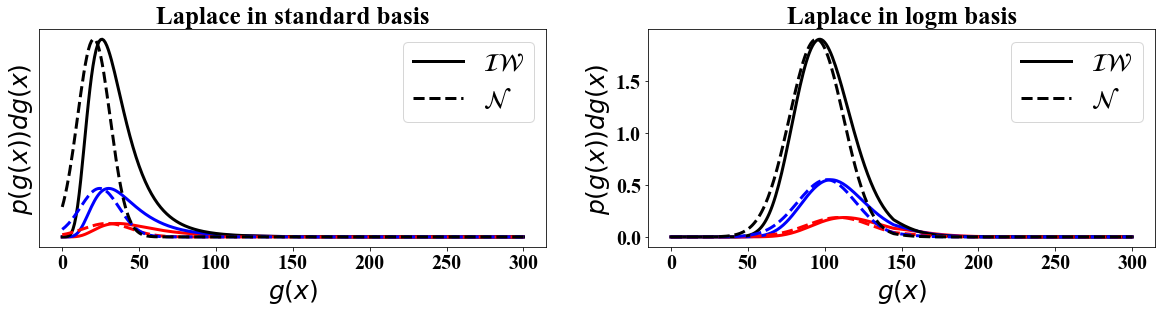

0.5000000000000001
(301, 2, 2)


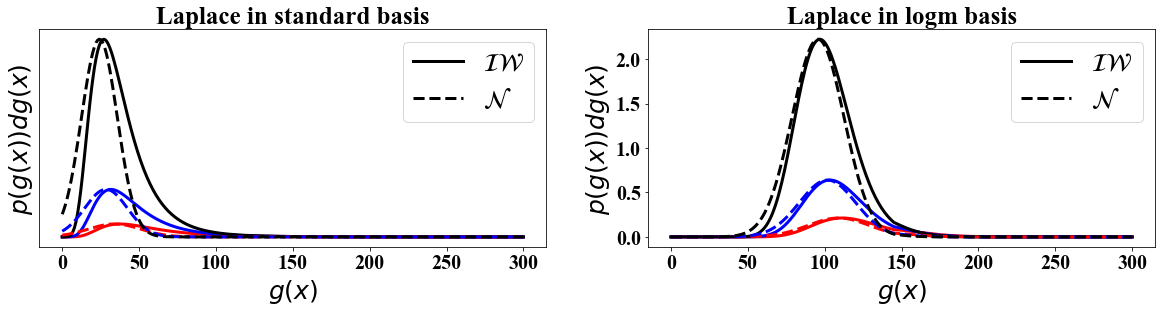

0.6
(301, 2, 2)


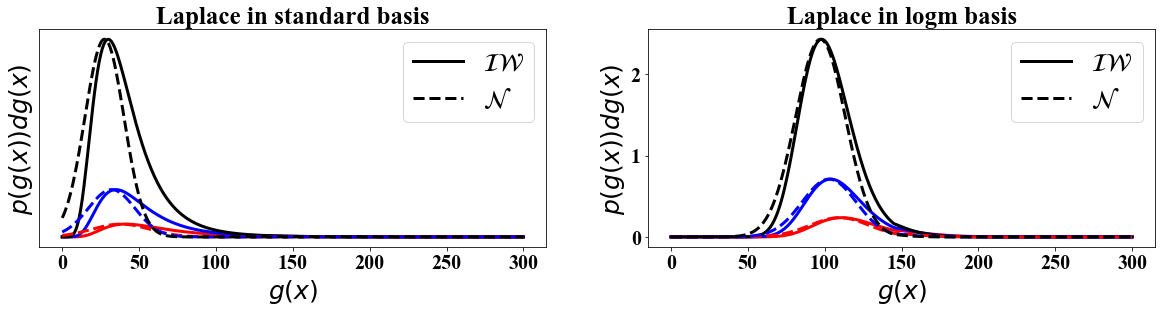

0.7000000000000001
(301, 2, 2)


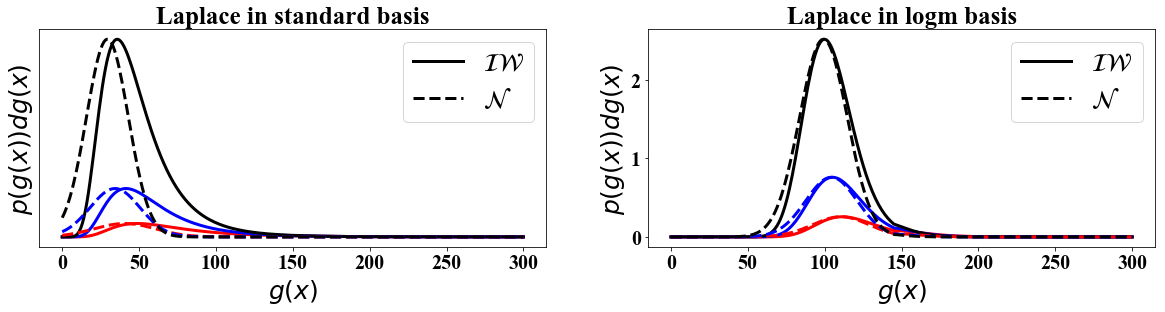

0.8000000000000002
(301, 2, 2)


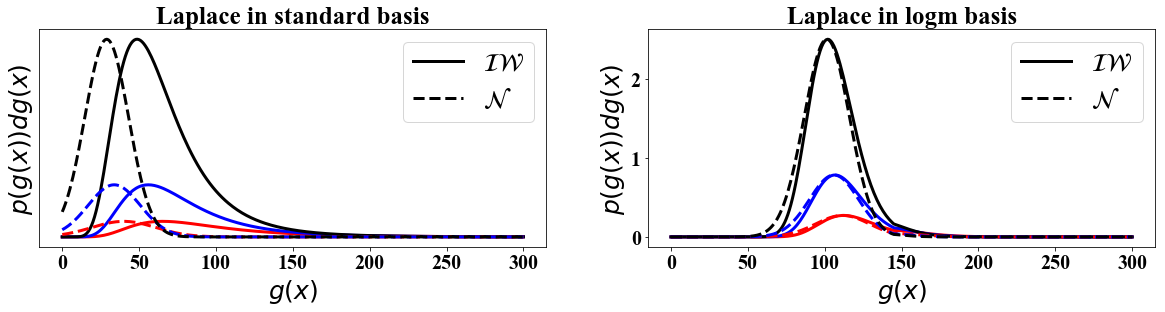

0.9
(301, 2, 2)


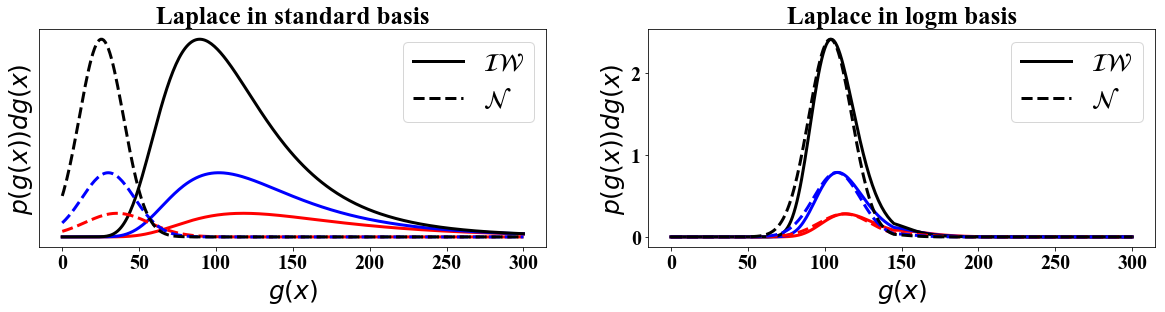

In [8]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

a_11 = np.linspace(0.1, 3.1, 300 +1)
a_22 = np.linspace(0.1, 3.1, 300 +1)

a_11_t = np.linspace(-2.9, 3.1, 300 +1)
a_22_t = np.linspace(-2.9, 3.1, 300 +1)


is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_cut(a_11_t, a_22_t, r)
    plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, show_back=False)

# sqrtm Bridge

In [9]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_inverse_Wishart_bridge_sqrtm(xx, xxt, ns, s, p=2, save=False, filename='', show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = inverse_wishart_mu(n1, p=p, Psi=s)
    mode2 = inverse_wishart_mu(n2, p=p, Psi=s)
    mode3 = inverse_wishart_mu(n3, p=p, Psi=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = inverse_wishart_Sigma(n1, p=p, Psi=s)
    sigma2 = inverse_wishart_Sigma(n2, p=p, Psi=s)
    sigma3 = inverse_wishart_Sigma(n3, p=p, Psi=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    iw1 = []
    iw2 = []
    iw3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        iw_1 = inverse_wishart_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_pdf(X=x, v=n3, Psi=s)
        iw1.append(iw_1)
        iw2.append(iw_2)
        iw3.append(iw_3)
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(iw1_lpa)
        normal2.append(iw2_lpa)
        normal3.append(iw3_lpa)

    iw1 = np.array(iw1)
    iw2 = np.array(iw2)
    iw3 = np.array(iw3)
    
    rescale_normal1 = np.max(iw1)/np.max(normal1)
    rescale_normal2 = np.max(iw2)/np.max(normal2)
    rescale_normal3 = np.max(iw3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    
    ######### sqrtm transformation

    mode1_t_sqrtm = inverse_wishart_t_sqrtm_mu(n1, p=p, Psi=s)
    mode2_t_sqrtm = inverse_wishart_t_sqrtm_mu(n2, p=p, Psi=s)
    mode3_t_sqrtm = inverse_wishart_t_sqrtm_mu(n3, p=p, Psi=s)

    sigma1_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n1, p=p, Psi=s)
    sigma2_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n2, p=p, Psi=s)
    sigma3_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n3, p=p, Psi=s)

    is_pos_def(sigma1_t_sqrtm)
    is_pos_def(sigma2_t_sqrtm)
    is_pos_def(sigma3_t_sqrtm)

    iw1_t_sqrtm = []
    iw2_t_sqrtm = []
    iw3_t_sqrtm = []
    iw1_lpa_t_sqrtm = []
    iw2_lpa_t_sqrtm = []
    iw3_lpa_t_sqrtm = []

    for x in xxt:
        iw_1 = inverse_wishart_t_sqrtm_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_t_sqrtm_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_t_sqrtm_pdf(X=x, v=n3, Psi=s)
        iw1_t_sqrtm.append(iw_1)
        iw2_t_sqrtm.append(iw_2)
        iw3_t_sqrtm.append(iw_3)
        #
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_sqrtm, Sigma=sigma1_t_sqrtm)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_sqrtm, Sigma=sigma2_t_sqrtm)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_sqrtm, Sigma=sigma3_t_sqrtm)
        iw1_lpa_t_sqrtm.append(iw1_lpa)
        iw2_lpa_t_sqrtm.append(iw2_lpa)
        iw3_lpa_t_sqrtm.append(iw3_lpa)

    #rescale for visibility
    iw1_t_sqrtm = np.array(iw1_t_sqrtm)
    iw2_t_sqrtm = np.array(iw2_t_sqrtm)
    iw3_t_sqrtm = np.array(iw3_t_sqrtm)
    
    rescale1_t_sqrtm = np.max(iw1_t_sqrtm)/np.max(iw1_lpa_t_sqrtm)
    rescale2_t_sqrtm = np.max(iw2_t_sqrtm)/np.max(iw2_lpa_t_sqrtm)
    rescale3_t_sqrtm = np.max(iw3_t_sqrtm)/np.max(iw3_lpa_t_sqrtm)

    iw1_lpa_t_sqrtm = np.array(iw1_lpa_t_sqrtm) * rescale1_t_sqrtm
    iw2_lpa_t_sqrtm = np.array(iw2_lpa_t_sqrtm) * rescale2_t_sqrtm
    iw3_lpa_t_sqrtm = np.array(iw3_lpa_t_sqrtm) * rescale3_t_sqrtm

    ######### back transform #########

    iw1_back = []
    iw2_back = []
    iw3_back = []

    for x in xx:
        iw1_back.append(log_mv_normal_back(x, mode1_t_sqrtm, sigma1_t_sqrtm))
        iw2_back.append(log_mv_normal_back(x, mode2_t_sqrtm, sigma2_t_sqrtm))
        iw3_back.append(log_mv_normal_back(x, mode3_t_sqrtm, sigma3_t_sqrtm))
        
    rescale_back1 = np.max(iw1)/np.max(iw1_back)
    rescale_back2 = np.max(iw2)/np.max(iw2_back)
    rescale_back3 = np.max(iw3)/np.max(iw3_back)

    iw1_back = np.array(iw1_back) * rescale_back1
    iw2_back = np.array(iw2_back) * rescale_back2 
    iw3_back = np.array(iw3_back) * rescale_back3 

    """Plots"""
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    xlabel_size=25
    ylabel_size=25
    title_size=25
    lw = 3

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(26,6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,4))
        
    axs[0].plot(iw1, 'r-', lw=lw)
    axs[0].plot(iw2, 'b-', lw=lw)
    axs[0].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size})

    axs[1].plot(iw1_t_sqrtm, 'r', lw=lw)
    axs[1].plot(iw2_t_sqrtm, 'b', lw=lw)
    axs[1].plot(iw3_t_sqrtm, 'k', lw=lw, label="$\mathcal{IW}$")
    axs[1].plot(iw1_lpa_t_sqrtm, 'r--', lw=lw)
    axs[1].plot(iw2_lpa_t_sqrtm, 'b--', lw=lw)
    axs[1].plot(iw3_lpa_t_sqrtm, 'k--', lw=lw, label="$\mathcal{N}$")
    #axs[1].set_yticklabels([])
    #axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in sqrtm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size})

    if show_back:
        axs[2].plot(iw1, 'r-', lw=lw)
        axs[2].plot(iw2, 'b-', lw=lw)
        axs[2].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$");
        axs[2].plot(iw1_back, 'r--', lw=lw)
        axs[2].plot(iw2_back, 'b--', lw=lw)
        axs[2].plot(iw3_back, 'k--', lw=lw, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    if save:
        plt.savefig(filename)
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


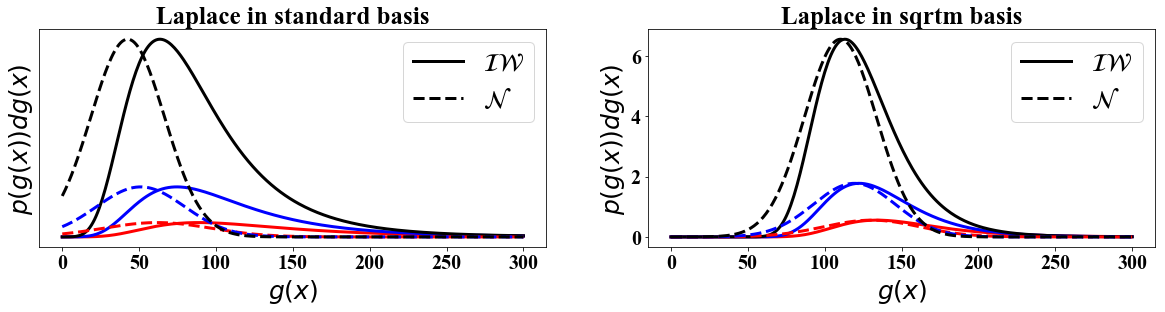

In [10]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 1.3, 300 +1)
a_22 = np.linspace(0.1, 1.3, 300 +1)

a_11_t = np.linspace(0.1, 1.5, 300 +1)
a_22_t = np.linspace(0.1, 1.5, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 0.5*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

r = 0.3
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=True,
                                  filename='inverse_wishart_sqrtm_bridge.pdf', show_back=False)


-0.9
(301, 2, 2)


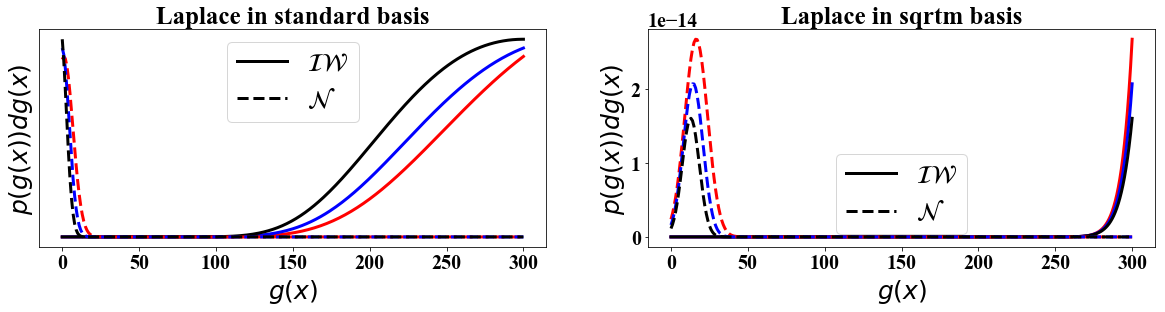

-0.8
(301, 2, 2)


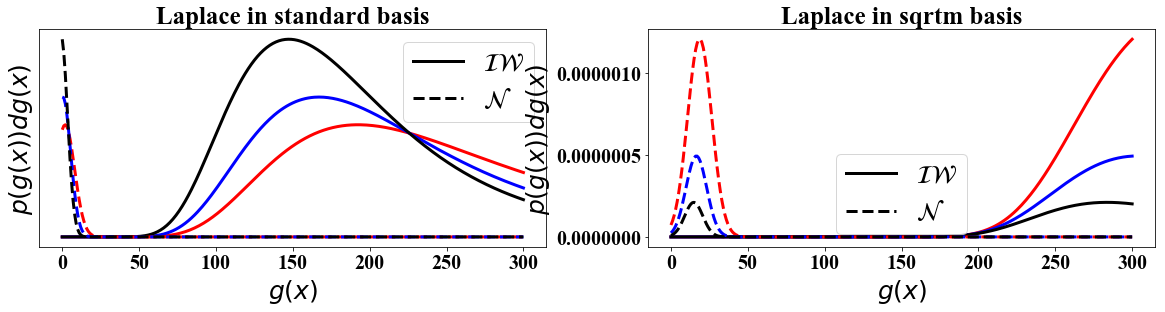

-0.7
(301, 2, 2)


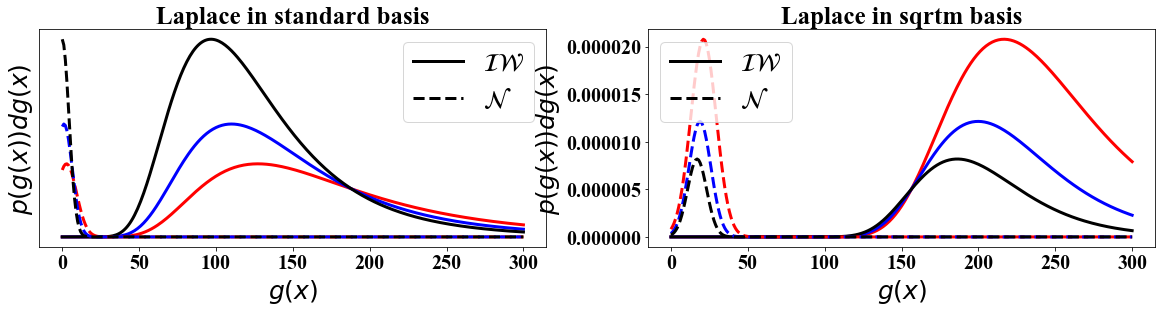

-0.6
(301, 2, 2)


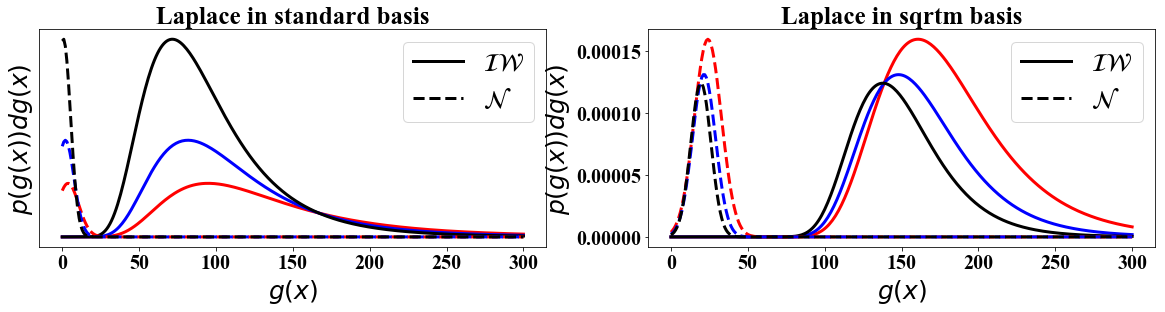

-0.5
(301, 2, 2)


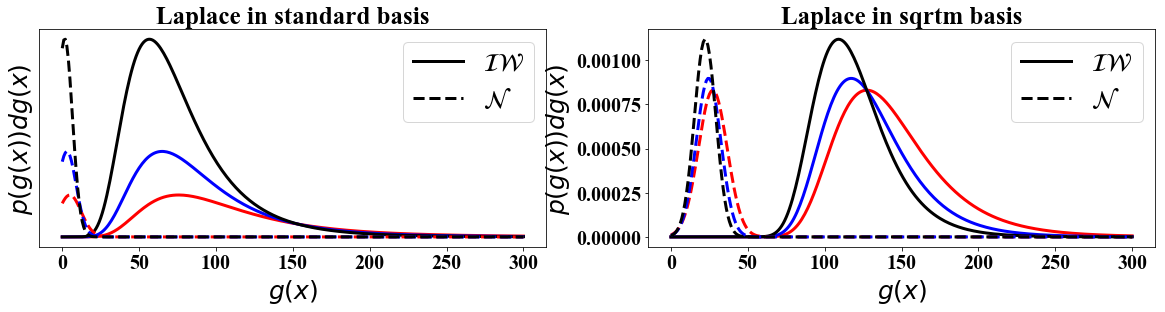

-0.4
(301, 2, 2)


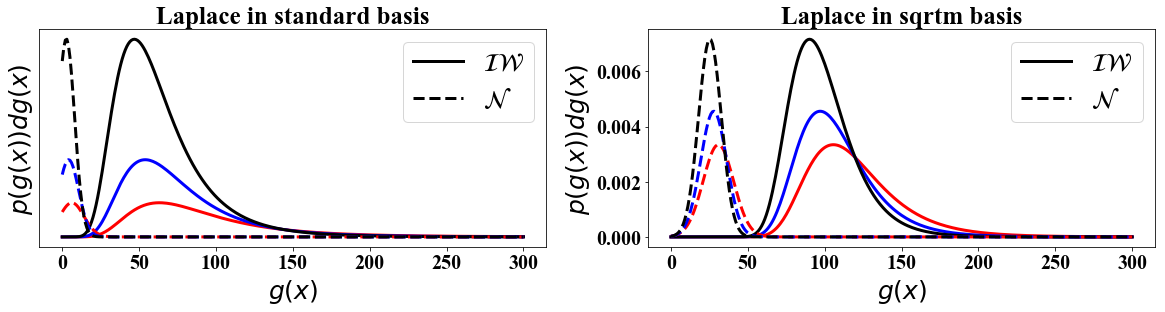

-0.29999999999999993
(301, 2, 2)


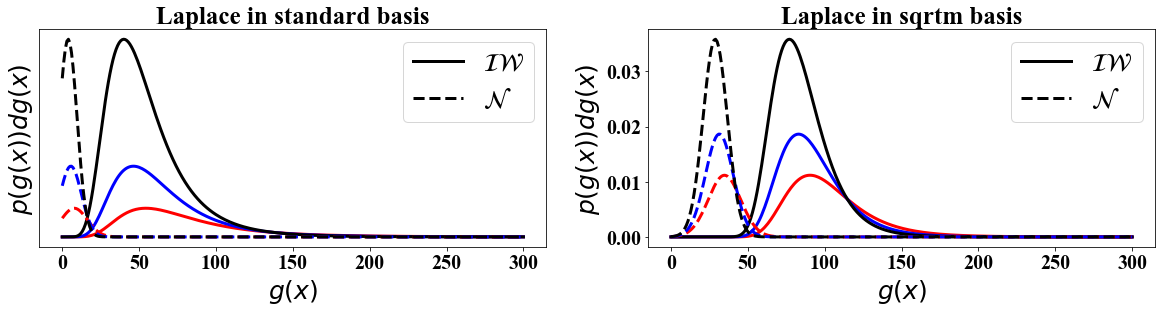

-0.19999999999999996
(301, 2, 2)


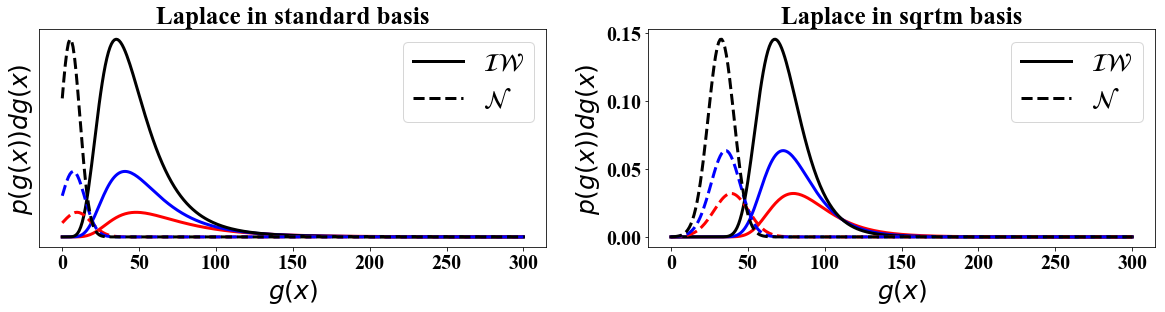

-0.09999999999999998
(301, 2, 2)


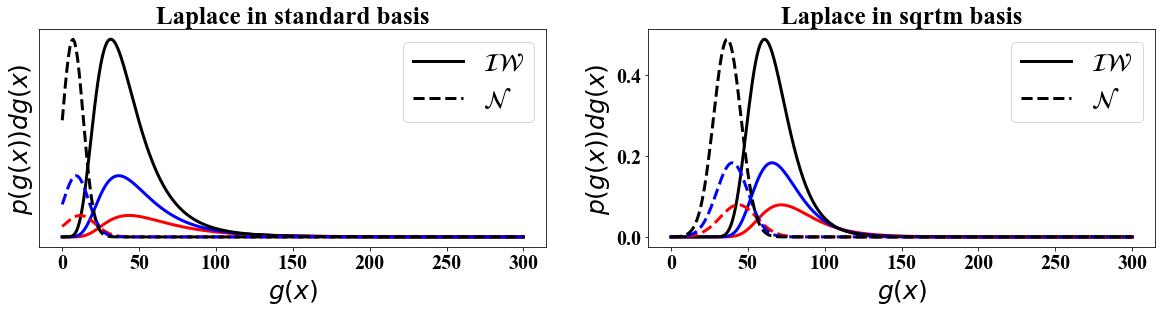

0.0
(301, 2, 2)


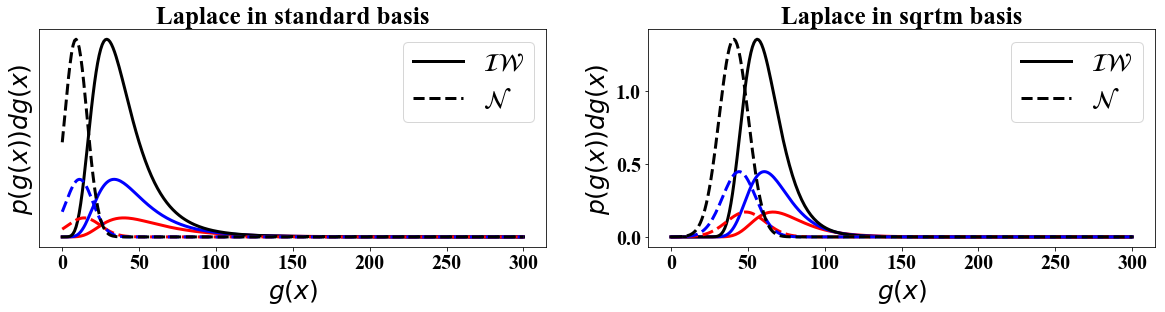

0.09999999999999998
(301, 2, 2)


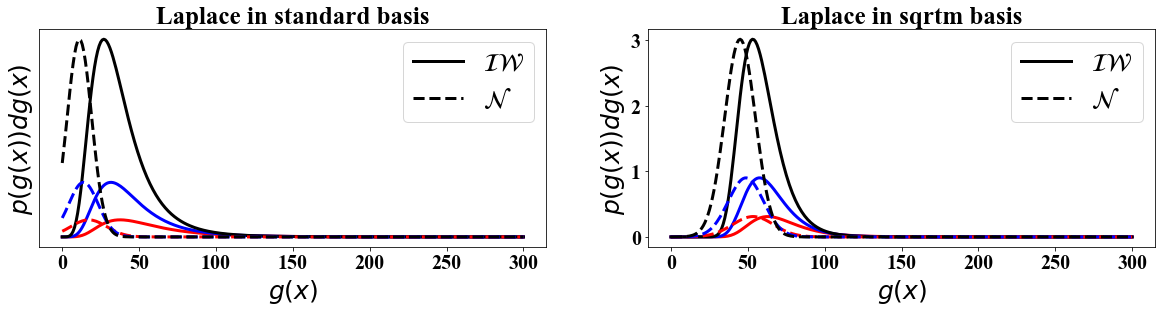

0.20000000000000007
(301, 2, 2)


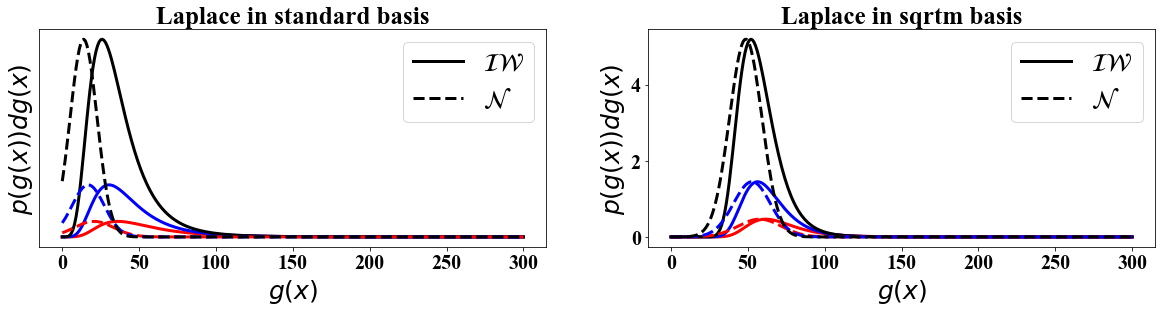

0.30000000000000016
(301, 2, 2)


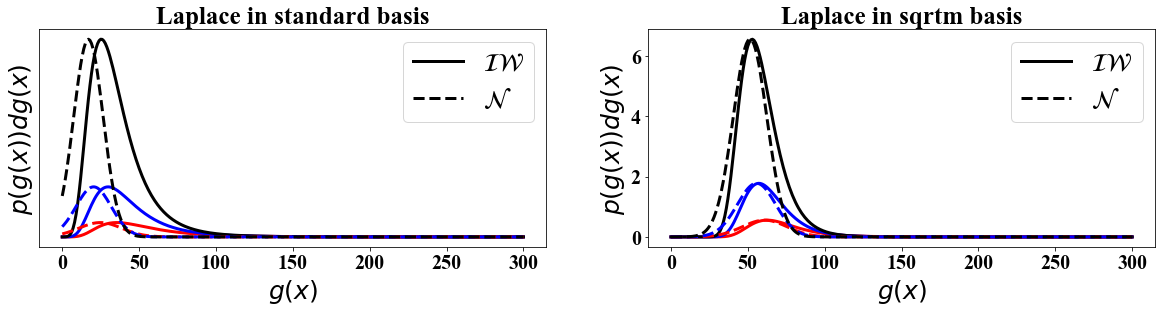

0.4
(301, 2, 2)


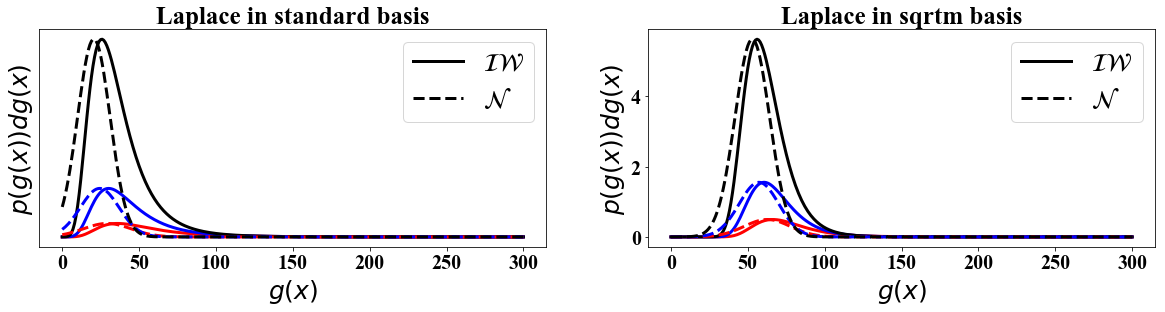

0.5000000000000001
(301, 2, 2)


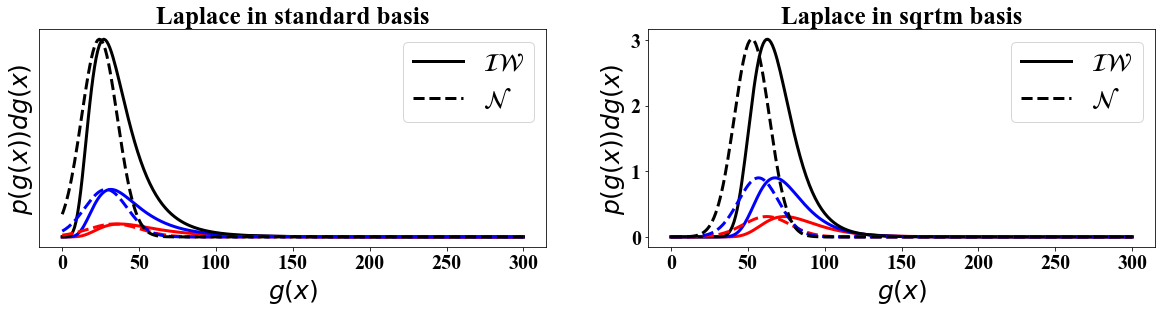

0.6
(301, 2, 2)


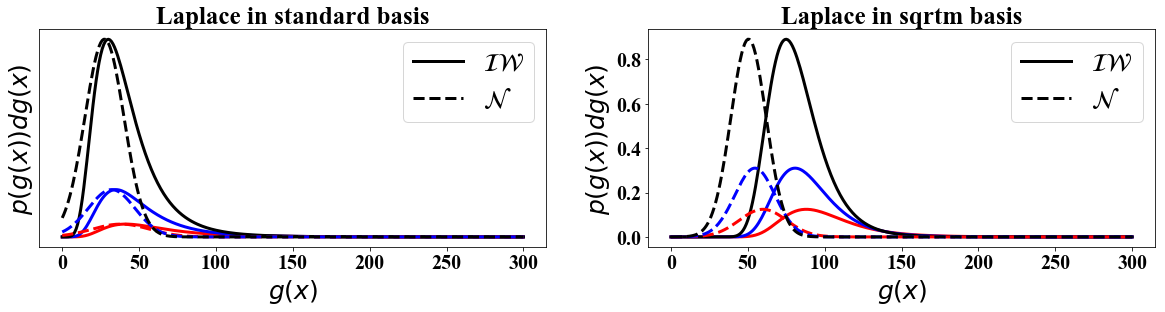

0.7000000000000001
(301, 2, 2)


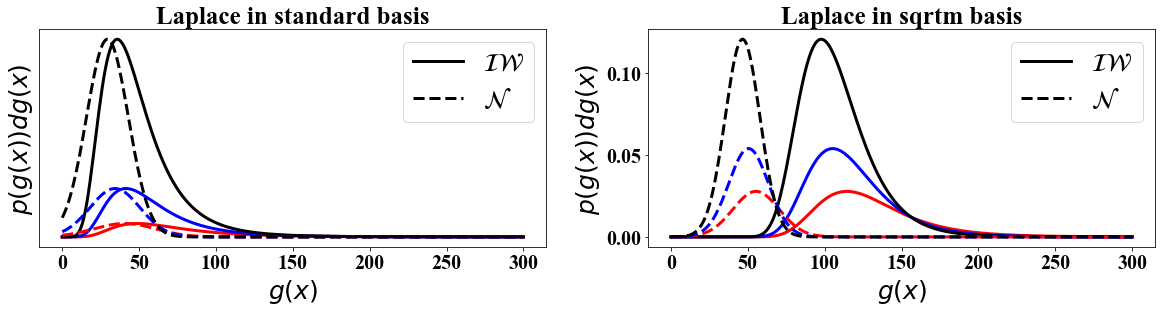

0.8000000000000002
(301, 2, 2)


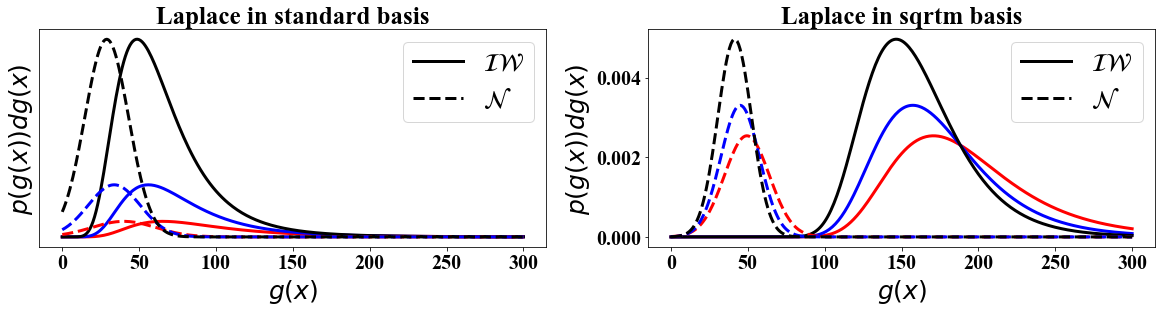

0.9
(301, 2, 2)


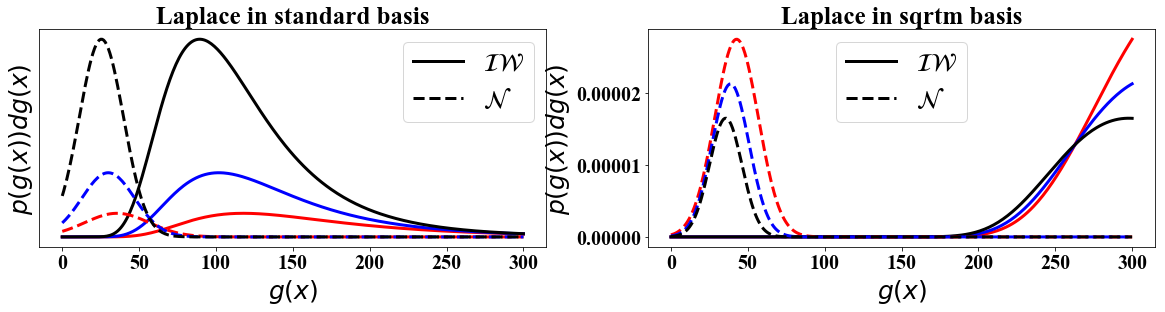

In [11]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

a_11 = np.linspace(0.1, 3.1, 300 +1)
a_22 = np.linspace(0.1, 3.1, 300 +1)

a_11_t = np.linspace(0.1, 3.1, 300 +1)
a_22_t = np.linspace(0.1, 3.1, 300 +1)

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_cut(a_11_t, a_22_t, r)
    plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, show_back=False)

# Statistical distance measures

In [12]:
from torch_two_sample import MMDStatistic
from scipy.stats import invwishart
from scipy.stats import multivariate_normal as mv_norm
import torch

## starting with MMD for 25 pairs of parameters

In [13]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    Ns = params[0]
    Vs = params[1]
    p = np.shape(Vs[0])[0]
    
    MMD_sum = 0
    MMD_t_logm_sum = 0 
    MMD_t_sqrtm_sum = 0 

    for n in Ns:
        for v in Vs:
            
            if verbose:
                print("n: ", n, "V: ", v)

            if n <= p +1 :
                print("n <= p + 1 doesn't yield a Laplace Approximation in standard basis")

            #get samples from all dists
            #standard
            IW_samples = invwishart.rvs(n, v, size=n_samples)
            if n > p + 1:         
                mode1 = inverse_wishart_mu(n, p, v).reshape(-1)
                Sigma1 = inverse_wishart_Sigma(n, p, v)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #logm
            mode1_logm = inverse_wishart_t_logm_mu(n, p, v).reshape(-1)
            Sigma1_logm = inverse_wishart_t_logm_Sigma(n, p, v)
            IW_samples_logm = np.array([logm(iw) for iw in IW_samples])
            N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
            
            
            #sqrtm
            mode1_sqrtm = inverse_wishart_t_sqrtm_mu(n, p, v).reshape(-1)
            Sigma1_sqrtm = inverse_wishart_t_sqrtm_Sigma(n, p, v)
            IW_samples_sqrtm = np.array([sqrtm(iw) for iw in IW_samples])
            N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            IW_samples_ = torch.Tensor(IW_samples.reshape((n_samples, -1)))
            if n > p + 1:         
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(IW_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #logm
            IW_samples_logm_ = torch.Tensor(IW_samples_logm.reshape((n_samples, -1)))
            N_samples_logm_ = torch.Tensor(N_samples_logm.reshape((n_samples, -1)))
            MMD_logm_= MMD(IW_samples_logm_, N_samples_logm_,  alphas=[0.5], ret_matrix=False)
            MMD_logm_= torch.max(torch.zeros(1), MMD_logm_)
            
            #sqrtm
            IW_samples_sqrtm_ = torch.Tensor(IW_samples_sqrtm.reshape((n_samples, -1)))
            N_samples_sqrtm_ = torch.Tensor(N_samples_sqrtm.reshape((n_samples, -1)))
            MMD_sqrtm_= MMD(IW_samples_sqrtm_, N_samples_sqrtm_,  alphas=[0.5], ret_matrix=False)
            MMD_sqrtm_= torch.max(torch.zeros(1), MMD_sqrtm_)

            if plot:
                rhos = np.linspace(-0.9, 0.9, 19)
                a_11 = np.linspace(0.1, 3.1, 300 +1)
                a_22 = np.linspace(0.1, 3.1, 300 +1)

                a_11_t = np.linspace(-2.9, 3.1, 300 +1)
                a_22_t = np.linspace(-2.9, 3.1, 300 +1)
                
                print("Logm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    xxt = make_2D_cut(a_11_t, a_22_t, r)
                    plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')

                print("Sqrtm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    xxt = make_2D_cut(a_11_t, a_22_t, r)
                    plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')

            if verbose: 
                print("standard: ", MMD_.item(), "logm: ", MMD_logm_.item(), "sqrtm: ", MMD_sqrtm_.item())

            #add them to their respective sums
            MMD_sum += MMD_
            MMD_t_logm_sum += MMD_logm_
            MMD_t_sqrtm_sum += MMD_sqrtm_

    return(MMD_sum.item(), MMD_t_logm_sum.item(), MMD_t_sqrtm_sum.item())

In [14]:
np.random.seed(42)
random_Vs = [create_spd_matrix(p=3, eps=10e-3) for _ in range(5)]
MMD_combinations(params=[range(4,9), random_Vs], plot=False, verbose=True, n_samples=2000)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
n:  4 V:  [[0.28911364 0.3606069  0.41836995]
 [0.3606069  1.0919819  0.28560883]
 [0.41836995 0.28560883 0.74257845]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.9257356652720173e-07
standard:  nan logm:  0.09743049740791321 sqrtm:  0.2675764560699463
n:  4 V:  [[0.17136317 0.2630103  0.2453433 ]
 [0.2630103  0.51736397 0.58939207]
 [0.2453433  0.58939207 0.83946276]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.5832366932815973e-07
standard:  nan logm:  0.09455563873052597 sqrtm:  0.24874907732009888
n:  4 V:  [[0.83361304 0.32439378 0.4248772 ]
 [0.32439378 0.3520234  0.25776768]
 [0.4248772  0.25776768 0.26734266]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.17994942

(nan, 2.934234380722046, 3.300706624984741)

In [15]:
results_MMD = np.array([4.9470319747924805, 2.7351322174072266, 3.4108450412750244])
results_MMD_normed = results_MMD/results_MMD[0]
print(results_MMD_normed)

[1.         0.55288347 0.68947301]


## KL-divergence (mode seeking/backward, from samples)

In [16]:
# check out Samples vs Dir
# True distributions belong to samples_1
# Laplace approximations belong to samples_2

def KL_divergence_samples(samples_1, samples_2, plot=False):
    
    assert(len(samples_1) == len(samples_2))
    n_bins = 10000
    
    if not isinstance(samples_1, np.ndarray):
        samples_1 = samples_1.numpy()
        samples_2 = samples_2.numpy()
    
    #make histograms
    hist1, _ = np.histogramdd(samples_1, density=True, bins=[10, 10, 10, 10])
    hist2, _ = np.histogramdd(samples_2, density=True, bins=[10, 10, 10, 10])

    
    #don't divide by 0
    hist1 += 1e-8
    hist2 += 1e-8
    
    #calculate KL_div
    KL_div = (hist1 * np.log(hist1 / hist2))

    if plot:
        print("plotting 1D marginal of the Wishart which is a Chi-squared")
        plt.plot(hist1[4,:,4], label='hist1')
        plt.plot(hist2[4,:,4], label='hist2')
        plt.plot(KL_div[4,:,4], lw=1, label='KL_div')
        plt.legend()
        plt.show()
            
    KL_div = np.sum(np.abs(KL_div))/n_bins
    
    #normalize for fair comparison
    KL_div /= np.max(hist1)
        
    return(KL_div)

# Statistical distance measures for small, medium and large $\theta$

In [17]:
np.random.seed(42)
p_=2

n_s, v_s = p_+0, create_spd_matrix(p=p_, eps=10e-3)
n_m, v_m = p_+2, create_spd_matrix(p=p_, eps=10e-3) 
n_l, v_l = p_+10, create_spd_matrix(p=p_, eps=10e-3)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True


## calculate MMD for the three pairs of parameters

In [18]:
# use 10 seeds
MMD_results_s = []
MMD_results_m = []
MMD_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)
    MMD_s = MMD_combinations(params = [[n_s], [v_s]], n_samples=2000)
    MMD_m = MMD_combinations(params = [[n_m], [v_m]], n_samples=2000, plot=False)
    MMD_l = MMD_combinations(params = [[n_l], [v_l]], n_samples=2000)
    MMD_results_s += [MMD_s]
    MMD_results_m += [MMD_m]
    MMD_results_l += [MMD_l]
    
MMD_results_mean_s = np.array(MMD_results_s).mean(0)
MMD_results_mean_m = np.array(MMD_results_m).mean(0)
MMD_results_mean_l = np.array(MMD_results_l).mean(0)
print(MMD_results_mean_s)
print(MMD_results_mean_m)
print(MMD_results_mean_l)

seed:  0
n:  2 V:  [[0.8887011  0.08908975]
 [0.08908975 0.9211197 ]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.8753740688430042e-07
standard:  nan logm:  0.11341142654418945 sqrtm:  0.435589998960495
n:  4 V:  [[0.9909938  0.789973  ]
 [0.789973   0.64614815]]
logm result may be inaccurate, approximate err = 2.189810939560911e-07
standard:  0.19542884826660156 logm:  0.1238703727722168 sqrtm:  0.11046195030212402
n:  12 V:  [[0.54086286 0.16822174]
 [0.16822174 0.55443984]]
logm result may be inaccurate, approximate err = 5.325985820710934e-08
standard:  0.0012984275817871094 logm:  0.042528629302978516 sqrtm:  0.0031874775886535645
seed:  1
n:  2 V:  [[0.8887011  0.08908975]
 [0.08908975 0.9211197 ]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.8753740688430042e-07
standard:  nan logm:  0.10738744586706161 sqrtm:  0.44522279500961304
n: 

In [19]:
# normalize to 1 for comparison
MMD_results_mean_s[0] = MMD_results_mean_s[1:].max()
MMD_results_mean_s_normalized = MMD_results_mean_s/MMD_results_mean_s.max()
MMD_results_mean_s_normalized[0] = np.nan
print(MMD_results_mean_s_normalized)
print(MMD_results_mean_m/MMD_results_mean_m.max())
print(MMD_results_mean_l/MMD_results_mean_l.max())

[      nan 0.2463138 1.       ]
[1.         0.66296437 0.56639152]
[0.03108019 1.         0.07527775]


## calculate KL div for the three pairs of parameters

In [20]:
def KL_combinations(params, n_samples=10000, verbose=True, plot=False):
    
    n = params[0]
    v = np.array(params[1])
    p = v[0].shape[0]

    if n <= p + 1:
        print("Wishart has no valid Laplace Approximation in standard base for n <= p+1")
    
    IW_samples = np.array([x.reshape(-1) for x in invwishart.rvs(n, v, size=n_samples)])
    
    if n > p + 1:
        mu = inverse_wishart_mu(n, p, v).reshape(-1)
        Sigma = inverse_wishart_Sigma(n, p, v)
        N_samples = mv_norm.rvs(mu, Sigma, size=n_samples)
    
    print(np.shape(IW_samples))
    
    if n > p+1:
        KL_ = KL_divergence_samples(IW_samples, N_samples, plot=plot)
    else:
        KL_ = torch.Tensor([np.nan])
    
    ####logm base
    mode1_logm = inverse_wishart_t_logm_mu(n, p, v).reshape(-1)
    Sigma1_logm = inverse_wishart_t_logm_Sigma(n, p, v)
    IW_samples_logm = np.array([logm(iw.reshape(p,p)).reshape(-1) for iw in IW_samples])
    N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
    
    KL_logm_ = KL_divergence_samples(IW_samples_logm, N_samples_logm, plot=False)
    
    ####sqrtm base
    mode1_sqrtm = inverse_wishart_t_sqrtm_mu(n, p, v).reshape(-1)
    Sigma1_sqrtm = inverse_wishart_t_sqrtm_Sigma(n, p, v)
    IW_samples_sqrtm = np.array([sqrtm(iw.reshape(p,p)).reshape(-1) for iw in IW_samples])
    N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)
    
    KL_sqrtm_ = KL_divergence_samples(IW_samples_sqrtm, N_samples_sqrtm, plot=False)
    
    if plot:
        rhos = np.linspace(-0.9, 0.9, 19)
        a_11 = np.linspace(0.1, 3.1, 300 +1)
        a_22 = np.linspace(0.1, 3.1, 300 +1)

        a_11_t = np.linspace(-2.9, 3.1, 300 +1)
        a_22_t = np.linspace(-2.9, 3.1, 300 +1)

        print("Logm base")
        for r in rhos:

            print(r)
            xx = make_2D_psd_cone_cut(a_11, a_22, r)
            xxt = make_2D_cut(a_11_t, a_22_t, r)
            plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')

        print("Sqrtm base")
        for r in rhos:

            print(r)
            xx = make_2D_psd_cone_cut(a_11, a_22, r)
            xxt = make_2D_cut(a_11_t, a_22_t, r)
            plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')
    
    if verbose: 
            print("standard: ", KL_.item(), "logm: ", KL_logm_.item(), "sqrtm: ", KL_sqrtm_.item())
            
    return([KL_, KL_logm_, KL_sqrtm_])

In [21]:
# use 10 seeds
KL_results_s = []
KL_results_m = []
KL_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)    
    KL_s = KL_combinations(params = [n_s, v_s], n_samples=10000, plot=False)
    KL_m = KL_combinations(params = [n_m, v_m], n_samples=10000, plot=False)
    KL_l = KL_combinations(params = [n_l, v_l], n_samples=10000, plot=False)
    KL_results_s += [KL_s]
    KL_results_m += [KL_m]
    KL_results_l += [KL_l]
    
KL_results_mean_s = np.array(KL_results_s).mean(0)
KL_results_mean_m = np.array(KL_results_m).mean(0)
KL_results_mean_l = np.array(KL_results_l).mean(0)
print(KL_results_mean_s)
print(KL_results_mean_m)
print(KL_results_mean_l)

seed:  0
Wishart has no valid Laplace Approximation in standard base for n <= p+1
(10000, 4)
logm result may be inaccurate, approximate err = 1.8753740688430042e-07
standard:  nan logm:  0.009038581103224322 sqrtm:  2.946497759320524
(10000, 4)
logm result may be inaccurate, approximate err = 2.189810939560911e-07
standard:  0.0012142296950810572 logm:  0.010462265948657606 sqrtm:  0.003122565455578749
(10000, 4)
logm result may be inaccurate, approximate err = 5.325985820710934e-08
standard:  0.00950115432113547 logm:  0.015133765552049318 sqrtm:  0.018361248423344512
seed:  1
Wishart has no valid Laplace Approximation in standard base for n <= p+1
(10000, 4)
logm result may be inaccurate, approximate err = 1.8753740688430042e-07
standard:  nan logm:  0.01029981983320064 sqrtm:  3.2272607982648247
(10000, 4)
logm result may be inaccurate, approximate err = 2.189810939560911e-07
standard:  0.00490722221549924 logm:  0.00852556926338789 sqrtm:  0.0017889200823940504
(10000, 4)
logm resu

In [22]:
# normalize to 1 for comparison
KL_results_mean_s[0] = KL_results_mean_s[1:].max()
KL_results_mean_s_normalized = KL_results_mean_s/KL_results_mean_s.max()
KL_results_mean_s_normalized[0] = np.nan
print(KL_results_mean_s_normalized)
print(KL_results_mean_m/KL_results_mean_m.max())
print(KL_results_mean_l/KL_results_mean_l.max())

[       nan 0.00267139 1.        ]
[0.18688121 1.         0.2474715 ]
[0.49709201 0.96744797 1.        ]


# test zone

In [23]:


def inverse_wishart_t_sqrtm_mu(nu, p, Psi):
    r =  sqrtm(1/(nu+p) * Psi)
    return(r.reshape(p,p))

def sym_kron_prod(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = A[i,k]*B[j,l]
                    x2 = A[i,l]*B[j,k]
                    x3 = A[j,k]*B[i,l]
                    x4 = A[j,l]*B[i,k]
                    K[n*k + j, n*i + l] = x1 + x2 + x3 + x4
                     
    return(1/4 * K)
